<a href="https://colab.research.google.com/github/vaishnavi-200318/rcnn/blob/main/Copy_of_Roboflow_Train_Detectron_2_Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train Detectron2 for Custom Instance Segmentation

This tutorial is based on the [Detectron2 repository](https://github.com/facebookresearch/detectron2) by Facebook. This notebook shows training on **your own custom instance segmentation objects**.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Detectron2 for custom instance segmentation](https://blog.roboflow.ai/custom-detectron2-instance-segmentation/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Detectron2 on your custom instance segmentation objects. We use a public [American Sign Language instance segmentation dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our segmenter we take the following steps:

* Install Detectron2 dependencies
* Download custom instance segmentation data from Roboflow
* Visualize Detectron2 training data
* Write our Detectron2 Training configuration
* Run Detectron2 training
* Evaluate Dectron2 performance
* Run Detectron2 inference on test images
* Export saved Detectron2 weights for future inference

### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)

# Install Roboflow and Detectron2 Pip Packages, Import Deps

In [ ]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-gbm4wng5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-gbm4wng5
  Resolved https://github.com/facebookresearch/detectron2.git to commit 2a420edb307c9bdf640f036d3b196bed474b8593
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

# Download dataset via Roboflow pip package and show a sample annotation

In [ ]:


from roboflow import Roboflow
rf = Roboflow(api_key="6yP6iQ3QFYpwR4f1uzWO")
project = rf.workspace("project-road-damage").project("yolo-v8-set")
version = project.version(1)
dataset = version.download("coco-segmentation")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to yolo-v8-set-1 in coco-segmentation:: 100%|██████████| 36/36 [00:00<00:00, 3096.51it/s]


In [ ]:
register_coco_instances("pol_train", {}, f"/content/yolo-v8-set-1/train/_annotations.coco.json", f"/content/yolo-v8-set-1/train")
register_coco_instances("pol_valid", {}, f"/content/yolo-v8-set-1/valid/_annotations.coco.json", f"/content/yolo-v8-set-1/valid")
register_coco_instances("pol_test", {}, f"/content/yolo-v8-set-1/test/_annotations.coco.json", f"/content/yolo-v8-set-1/test")

WARNING [07/23 01:10:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/23 01:10:12 d2.data.datasets.coco]: Loaded 20 images in COCO format from /content/yolo-v8-set-1/train/_annotations.coco.json


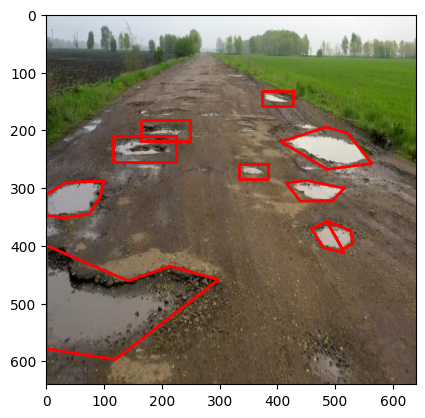

In [ ]:
dataset_train = DatasetCatalog.get("pol_train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

# Configure Detectron2 for fine tuning from COCO, Define training loop helper functions (from detectron2 repo), Run custom training loop

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pol_train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("pol_test",)#Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 30
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 # 26 letters plus one super class
cfg.TEST.EVAL_PERIOD = 0 # Increase this number if you want to monitor validation performance during training
cfg.MODEL.DEVICE = 'cpu'
PATIENCE = 10 #Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)

        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break

do_test(cfg, model)

[07/23 01:47:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [07/23 01:47:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/23 01:47:18 d2.data.datasets.coco]: Loaded 20 images in COCO format from /content/yolo-v8-set-1/train/_annotations.coco.json
[07/23 01:47:18 d2.data.build]: Removed 0 images with no usable annotations. 20 images left.
[07/23 01:47:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/23 01:47:18 d2.data.build]: Using training sampler TrainingSampler
[07/23 01:47:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/23 01:47:18 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[07/23 01:47:18 d2.data.common]: Serialized dataset takes 0.05 MiB
[07/23 01:47:18 d2.data.build]: Making batched data loader with batc

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[07/23 01:59:21 d2.utils.events]:  iter: 19  total_loss: 2.451  loss_cls: 0.9203  loss_box_reg: 0.3244  loss_mask: 0.6832  loss_rpn_cls: 0.4601  loss_rpn_loc: 0.1082     lr: 0.00015842  
[07/23 02:05:13 d2.utils.events]:  eta: 0:00:00  iter: 29  total_loss: 1.703  loss_cls: 0.4925  loss_box_reg: 0.3209  loss_mask: 0.6335  loss_rpn_cls: 0.1715  loss_rpn_loc: 0.1082     lr: 0.00024168  
WARNING [07/23 02:05:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/23 02:05:21 d2.data.datasets.coco]: Loaded 3 images in COCO format from /content/yolo-v8-set-1/test/_annotations.coco.json
[07/23 02:05:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/23 02:05:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/23 02:05:21 d2.data.common]: Serializing 3 ele

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[07/23 02:05:30 d2.evaluation.evaluator]: Inference done 1/3. Dataloading: 0.2870 s/iter. Inference: 7.8962 s/iter. Eval: 0.0938 s/iter. Total: 8.2794 s/iter. ETA=0:00:16
[07/23 02:05:38 d2.evaluation.evaluator]: Inference done 2/3. Dataloading: 0.1461 s/iter. Inference: 7.9418 s/iter. Eval: 0.0818 s/iter. Total: 8.1735 s/iter. ETA=0:00:08
[07/23 02:05:45 d2.evaluation.evaluator]: Inference done 3/3. Dataloading: 0.0000 s/iter. Inference: 7.1565 s/iter. Eval: 0.0943 s/iter. Total: 7.2508 s/iter. ETA=0:00:00
[07/23 02:05:45 d2.evaluation.evaluator]: Total inference time: 0:00:07.555810 (7.555810 s / iter per device, on 1 devices)
[07/23 02:05:45 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (7.156473 s / iter per device, on 1 devices)
[07/23 02:05:45 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/23 02:05:45 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/pol_test/coco_instances_results.json
[07/23 02:05:45 d2.evalua

OrderedDict([('bbox',
              {'AP': 3.9046820878297104,
               'AP50': 7.35185318237497,
               'AP75': 4.641089108910891,
               'APs': 0.053630363036303634,
               'APm': 7.482087867230745,
               'APl': 0.0,
               'AP-road-pothole': 3.9046820878297104}),
             ('segm',
              {'AP': 2.7738376033635026,
               'AP50': 7.35185318237497,
               'AP75': 0.40222772277227725,
               'APs': 0.14664674014571266,
               'APm': 5.451351971931887,
               'APl': 0.0,
               'AP-road-pothole': 2.7738376033635026})])

# Test model and show example output

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("pol_valid")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    im = Image.fromarray(out.get_image()[:, :, ::-1])
    im

[07/23 02:07:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [07/23 02:07:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/23 02:07:18 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/yolo-v8-set-1/valid/_annotations.coco.json


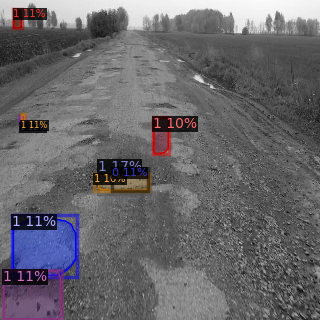

In [ ]:
im

# Download trained model for future inference

In [ ]:
from google.colab import files
files.download(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>